# 1. Import the Packages

In [91]:
# Standard Python libraries
import os
import random
import time
from datetime import datetime

# Libraries for data manipulation and visualization
import cv2
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

# Libraries for detection and classification
from mtcnn import MTCNN 
from keras_facenet import FaceNet

# 2. Data Set Aquisition

Capturing data set for new user from camera using MTCNN detector

In [41]:
def captureImage():
    # initialize the MTCNN detector
    detector = MTCNN()

    # initialize the video capture object for the default camera
    cam = cv2.VideoCapture(0)

    # initialize catured frame variable

    while True:
        # read the frame from the camera
        ret, frame = cam.read()

        # detect faces using MTCNN
        faces = detector.detect_faces(frame)

        # draw bounding boxes around the faces
        for face in faces:
            x, y, w, h = face['box']
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 2)

        # show the resulting frame
        cv2.imshow('Real-time Face Detection', frame)

        # press 'q' key to exit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # release the video capture object and close all windows
    cam.release()
    cv2.destroyAllWindows()

## 3. Preprocessing Image

### 3.1. MTCNN Part

Extract faces from captured image using MTCNN and resize the image into 160x160. After that, do flip and contrast stretching to resized image

In [88]:
class FACELOADING:
    def __init__(self, directory):
        self.directory = directory
        self.target_size = (160, 160)
        self.X = []
        self.Y = []
        self.detector = MTCNN()

    def extract_faces(self, filename):
        img = cv2.imread(filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        hasil_deteksi = self.detector.detect_faces(img)

        # Getting x, y, w, h from image 'box'
        x, y, w, h = hasil_deteksi[0]['box']
        x, y, w, h = abs(x), abs(y), abs(w), abs(h)

        # Draw rectangle box on detected face
        img = cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 10)

        wajah = img[y:y + h, x:x + w]
        wajah_arr = cv2.resize(wajah, self.target_size)
        return wajah_arr

    def load_faces(self, dir, class_label):
        FACES = []
        Y = []
        for im_name in os.listdir(dir):
            try:
                path = os.path.join(dir, im_name)
                single_face = self.extract_faces(path)
                FACES.append(single_face)
                Y.append(class_label)

            except Exception as e:
                pass
        return FACES, Y

    def parse_filename(self, filename):
        # Mengambil NIM dan Nama dari nama file dengan pola "NIM_Nama_i.jpg"
        nim, nama, _ = filename.split('_')
        return nim, nama

    def load_classes_after_augmentation(self, output_folder=None):
        # Inisialisasi kembali X dan Y
        X = []
        Y = []

        for sub_dir in os.listdir(self.directory):
            path = os.path.join(self.directory, sub_dir)
            FACES, labels = self.load_faces_after_augmentation(path, sub_dir, output_folder=output_folder)
            X.extend(FACES)
            Y.extend(labels)

        return X, Y

    def load_faces_after_augmentation(self, dir, class_label, output_folder=None):
        FACES = []
        Y = []
        for i, im_name in enumerate(os.listdir(dir)):
            try:
                path = os.path.join(dir, im_name)
                single_face = self.extract_faces(path)
                FACES.append(single_face)
                Y.append(class_label)

                nim, nama = self.parse_filename(im_name)

                # Jika ingin melakukan augmentasi pada citra di sini, tambahkan proses augmentasi di sini.
                flipped_face = cv2.flip(single_face, 1)  # 1 for horizontal flip
                FACES.append(flipped_face)
                Y.append(class_label)

                contrast_stretched_face = self.contrast_stretching(single_face)
                FACES.append(contrast_stretched_face)
                Y.append(class_label)

                if output_folder:
                    index_start = 1 + i * 3

                    # Simpan citra dengan penamaan yang mengikuti nim dan nama
                    original_filename = f"{nim}_{nama}_{index_start}.jpg"
                    output_path_original = os.path.join(output_folder, class_label, original_filename)
                    cv2.imwrite(output_path_original, cv2.cvtColor(single_face, cv2.COLOR_RGB2BGR))

                    flipped_filename = f"{nim}_{nama}_{index_start + 1}.jpg"
                    output_path_flip = os.path.join(output_folder, class_label, flipped_filename)
                    cv2.imwrite(output_path_flip, cv2.cvtColor(flipped_face, cv2.COLOR_RGB2BGR))

                    stretched_filename = f"{nim}_{nama}_{index_start + 2}.jpg"
                    output_path_stretch = os.path.join(output_folder, class_label, stretched_filename)
                    cv2.imwrite(output_path_stretch, cv2.cvtColor(contrast_stretched_face, cv2.COLOR_RGB2BGR))

            except Exception as e:
                pass
        return FACES, Y

    def contrast_stretching(self, image):
        # Compute minimum and maximum pixel values for each channel
        min_val = np.min(image, axis=(0, 1))
        max_val = np.max(image, axis=(0, 1))

        # Perform contrast stretching for each channel
        stretched = (image - min_val) * (255.0 / (max_val - min_val))
        stretched = np.clip(stretched, 0, 255).astype(np.uint8)

        return stretched

In [ ]:
# Gunakan kelas FACELOADING dengan folder direktori "capturedfaces"
face_loader = FACELOADING("capturedfaces")
X, Y = face_loader.load_classes_after_augmentation(output_folder="datawajah")

print(f"Unique Labels After Augmentation: {set(Y)}")
print(f'Total Images in Array After Augmentation: {len(X)} images')

Creating dataframe that containing available images from extracted faces and checking total files in the folder

In [77]:
# Initialize main dataset folder
capture_folder = "capturedfaces"

# Initialize main dataset folder
dataset_folder = "datawajah"

In [78]:
def create_dataframe():
    root_folder = dataset_folder

    data = []
  
    # Iterate through the main folder and subfolders
    for root, dirs, files in os.walk(root_folder):
        for file in files:
        # Get the subfolder name (classes)
            classes = os.path.basename(root)

            # Get the full path of the image
            image_path = os.path.join(classes, file)

            # Add data to the list
            data.append({'Classes': classes, 'File Name': file, 'Image Path': image_path})

    # Create a dataframe from the data list
    df = pd.DataFrame(data)

    # Save the dataframe to an Excel file
    excel_file_name = 'dataframe_and_model_files/faces_train_data.xlsx'
    df.to_excel(excel_file_name, index=False)

    print("Dataframe successfully saved to", excel_file_name)

    return df

In [79]:
def total_images_per_class(df):
    # Function to calculate the total number of files in a folder.
    def total_file(classes):
        return len(df[df['Classes'] == classes].values)

    # Iterate through unique classes and print the total number of files for each class
    unique_classes = df['Classes'].unique()
    print("Total number of images in each class :")
    for classes in unique_classes:
        count = total_file(classes)
        print(f"'{classes}': {count} images")

In [80]:
# Create the dataframe
df = create_dataframe()

# Calculate and print the total number of images in each class
total_images_per_class(df)

Dataframe successfully saved to dataframe_and_model_files/faces_train_data.xlsx
Total number of images in each class :
'rizky-mahesa-ramadhan': 150 images
'rizky-nurhadhi': 150 images


In [81]:
df.sample(5)

,Classes,File Name,Image Path
269,rizky-nurhadhi,1207070113_Rizky Nurhadhi_71.jpg,rizky-nurhadhi\1207070113_Rizky Nurhadhi_71.jpg
193,rizky-nurhadhi,1207070113_Rizky Nurhadhi_138.jpg,rizky-nurhadhi\1207070113_Rizky Nurhadhi_138.jpg
198,rizky-nurhadhi,1207070113_Rizky Nurhadhi_142.jpg,rizky-nurhadhi\1207070113_Rizky Nurhadhi_142.jpg
168,rizky-nurhadhi,1207070113_Rizky Nurhadhi_115.jpg,rizky-nurhadhi\1207070113_Rizky Nurhadhi_115.jpg
187,rizky-nurhadhi,1207070113_Rizky Nurhadhi_132.jpg,rizky-nurhadhi\1207070113_Rizky Nurhadhi_132.jpg


### 3.2. FaceNet Part

Embed the dataset to 512 dimension image (1x1x512) and save it into .npz file

In [82]:
embedder = FaceNet()

def get_embedding(face_image):
    face_image = face_image.astype('float32') # 3D(160x160x3)
    face_image = np.expand_dims(face_image, axis=0) # 4D(Nonex160x160x3)
    
    yhat = embedder.embeddings(face_image)

    return yhat[0] #512D image (1x1x152)

In [83]:
EMBEDDED_X = []

for face_image in X:
    EMBEDDED_X.append(get_embedding(face_image))

EMBEDDED_X = np.asarray(EMBEDDED_X)

1/1 [==============================] - 0s 86ms/step


In [84]:
embedded_file_name = "dataframe_and_model_files/embedded_dataset.npz"
np.savez_compressed(embedded_file_name, EMBEDDED_X, Y)
print("Embedded dataset successfully saved to", embedded_file_name)

print(f"Unique Labels: {set(Y)}")
print(f'Total Embedded Images in Array: {len(EMBEDDED_X)}')

Embedded dataset successfully saved to dataframe_and_model_files/embedded_dataset.npz
Unique Labels: {'rizky-nurhadhi', 'rizky-mahesa-ramadhan'}
Total Embedded Images in Array: 300


1/1 [==============================] - 0s 67ms/step


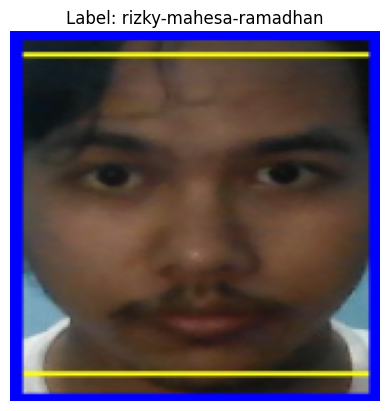

Embedded Vector: [ 0.05121416  0.06187363 -0.01230344  0.02968591  0.03540307 -0.01648149
  0.05117074  0.03208296 -0.02752223 -0.01667087  0.11374354 -0.02246894
  0.0051694  -0.02494686  0.02749168  0.06160789  0.05323968  0.07002414
 -0.05935078  0.03311546  0.00276824 -0.03504178  0.0278212  -0.05386693
 -0.0221757  -0.02346531  0.00042128 -0.08138084  0.02853298 -0.03096033
 -0.02637293  0.00703669 -0.06631413  0.06068513  0.01557956 -0.0014453
  0.07928672 -0.09915001  0.00075934  0.00890709  0.04270415 -0.05667362
 -0.00019113  0.00249652 -0.0557954   0.01294947 -0.04148174  0.04986291
 -0.01734833  0.0193084  -0.02883851 -0.06243445 -0.00768693  0.0258441
  0.01800925 -0.08097291 -0.04018175 -0.04125138  0.00641363  0.00789078
 -0.00418393  0.06933406 -0.05432952  0.06756929 -0.00978531 -0.08206167
 -0.02022407 -0.04652189  0.09291212 -0.05110394 -0.04796061 -0.0252336
 -0.02636506 -0.01084031  0.04896081 -0.0404418  -0.00620389 -0.04826787
  0.00348378 -0.03020518  0.0026567  

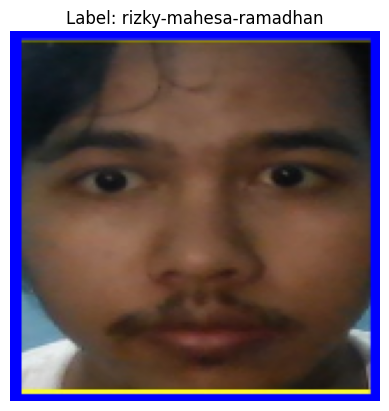

Embedded Vector: [ 3.63702662e-02  5.14691286e-02 -1.35275871e-02  3.71311419e-02
  6.06817976e-02 -8.70366953e-03  6.73911273e-02 -5.13024395e-03
 -1.17859337e-02 -5.08621335e-03  1.08384065e-01 -2.77594756e-02
  2.31603831e-02 -7.40862079e-03  2.53300760e-02  6.42176494e-02
  2.48451531e-02  4.89731431e-02 -7.84469619e-02  3.31869051e-02
 -2.51675881e-02 -2.54064407e-02  3.53201777e-02 -2.69426964e-02
 -3.80108915e-02  4.17144736e-03 -3.67770530e-02 -9.44895595e-02
  2.13166978e-02 -3.14409174e-02 -3.40308994e-02  2.72812508e-02
 -6.90804571e-02  3.59958075e-02  8.36398639e-03  3.06193195e-02
  1.32342339e-01 -1.01584904e-01 -1.86489429e-02  5.53877186e-03
  3.54956575e-02 -1.74794849e-02  3.10706440e-02 -9.17763636e-03
 -6.16039149e-02  4.19227593e-03 -6.51420839e-03  8.74627307e-02
 -4.65768278e-02  5.44727920e-03 -2.33229157e-02 -6.73689544e-02
 -1.30075924e-02  1.77045781e-02  3.30983591e-03 -8.41661245e-02
 -4.17085811e-02 -4.76148054e-02  1.04738763e-02  1.27249323e-02
 -2.0952

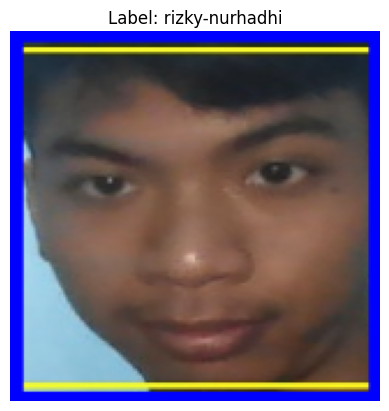

Embedded Vector: [ 4.61534336e-02  3.74703929e-02 -2.93199122e-02  1.51253166e-02
  6.93690851e-02 -2.81716362e-02  5.54717705e-02 -5.42755723e-02
 -4.83881012e-02  2.65885144e-02  2.89954096e-02 -6.93565756e-02
 -2.27287021e-02  2.51496807e-02  3.80560793e-02 -2.50202604e-02
  4.35231850e-02  7.36519173e-02 -3.02166548e-02  6.82735294e-02
  2.04465874e-02  3.47401272e-03  2.14678142e-02 -3.91893415e-03
  1.59851816e-02 -9.35249031e-03  4.19096276e-02 -5.58753014e-02
  7.35319704e-02 -5.09199351e-02 -2.10397877e-02  5.42660914e-02
 -2.82771457e-02  4.22876291e-02  4.98730391e-02 -3.23760770e-02
 -3.87891605e-02 -6.50389194e-02 -5.95609844e-03 -8.10395367e-03
 -4.86612320e-02 -6.11184798e-02 -4.08454016e-02 -4.69861701e-02
 -6.29028305e-02  3.21201980e-03 -3.70731391e-02  1.06247014e-03
 -1.58950984e-02  7.53855035e-02  3.32992226e-02 -1.08812995e-01
  2.81248568e-03  5.42843156e-02 -2.01354586e-02 -9.98791158e-02
 -2.69415770e-02 -2.61056877e-04  2.89758909e-02  1.56827159e-02
  2.7989

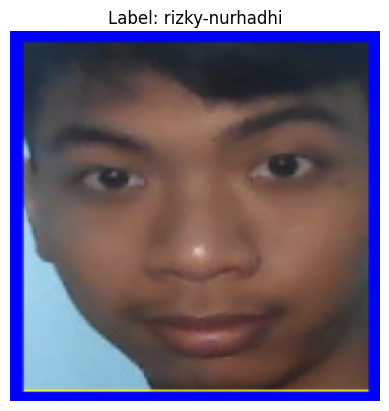

Embedded Vector: [ 5.43892495e-02  3.29762027e-02 -1.04795452e-02  4.03228588e-02
  6.76893964e-02 -2.91062426e-02  2.27209739e-02 -3.80907767e-02
 -6.54742196e-02  1.13996034e-02  3.36547121e-02 -4.13410850e-02
 -4.69898842e-02  2.65142918e-02  6.28262758e-02 -8.67337640e-03
  5.47339804e-02  6.28979132e-02 -4.33623791e-02  5.32201380e-02
  1.37330005e-02  1.88422874e-02  1.83621254e-02  2.24202010e-03
  1.72354863e-03 -1.05863689e-02  4.32333983e-02 -4.15670760e-02
  8.08195844e-02 -4.92099263e-02 -4.23674546e-02  4.71325479e-02
 -1.00994129e-02  2.00759321e-02  3.39254551e-02 -3.52209397e-02
 -5.66074140e-02 -8.17979351e-02  6.40455866e-03  6.37847697e-03
 -3.50250192e-02 -5.66318482e-02 -3.62820700e-02 -6.93916678e-02
 -2.57781837e-02  2.09172945e-02 -1.12673463e-02  9.41081322e-04
 -1.62420440e-02  1.01691179e-01  3.71397249e-02 -9.01248008e-02
  1.57990158e-02  3.92544977e-02 -2.06235982e-02 -9.20588002e-02
 -2.19302792e-02  1.23467040e-03  3.71459201e-02  5.30612608e-03
  9.1554

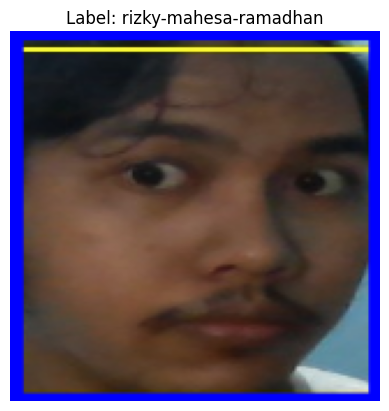

Embedded Vector: [ 5.46629466e-02  3.35554220e-02 -2.12793965e-02  3.73545177e-02
  5.45547418e-02 -2.10678261e-02  5.10014407e-02 -6.59716967e-03
  2.24421453e-02  3.19789648e-02  9.17780846e-02 -1.22435403e-03
 -1.41798761e-02 -1.20959114e-02 -1.45686856e-02  2.84074824e-02
  4.65219803e-02  1.02318592e-01 -5.21588959e-02  5.93006723e-02
 -4.03086804e-02 -8.70282948e-03  3.89945172e-02 -6.91305473e-02
 -5.52538931e-02 -1.08993202e-02 -2.70498544e-02 -7.99335465e-02
  1.15704481e-02 -2.51386818e-02 -2.56831646e-02  7.31823267e-03
 -4.83490005e-02  6.82233348e-02  2.72176731e-02 -8.99218066e-05
  6.83893561e-02 -9.19899940e-02 -1.90778803e-02  4.96535301e-02
  8.56844056e-03 -4.31913212e-02 -1.16994632e-02  2.48083044e-02
 -7.17681274e-02  2.48223953e-02 -2.22945884e-02  6.09382801e-02
 -1.76067483e-02  3.59212956e-03 -1.19336266e-02 -6.74108192e-02
 -9.76924598e-03  6.94090873e-02  3.32227885e-03 -7.49983490e-02
 -4.15557250e-02 -2.63365116e-02 -2.04034746e-02 -1.80001277e-02
 -9.0442

In [85]:
# Load the embedded dataset
loaded_data = np.load("dataframe_and_model_files/embedded_dataset.npz")
EMBEDDED_X, Y = loaded_data['arr_0'], loaded_data['arr_1']

# Select a few samples
num_samples = 5
selected_indices = np.random.choice(len(EMBEDDED_X), num_samples, replace=False)

# Iterate through samples and display original images and their embeddings
for index in selected_indices:
    original_image = X[index]
    label = Y[index]

    # Get the corresponding embedded vector
    embedded_vector = get_embedding(original_image)

    # Display the original image
    plt.imshow(original_image)
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()

    print(f"Embedded Vector: {embedded_vector}")

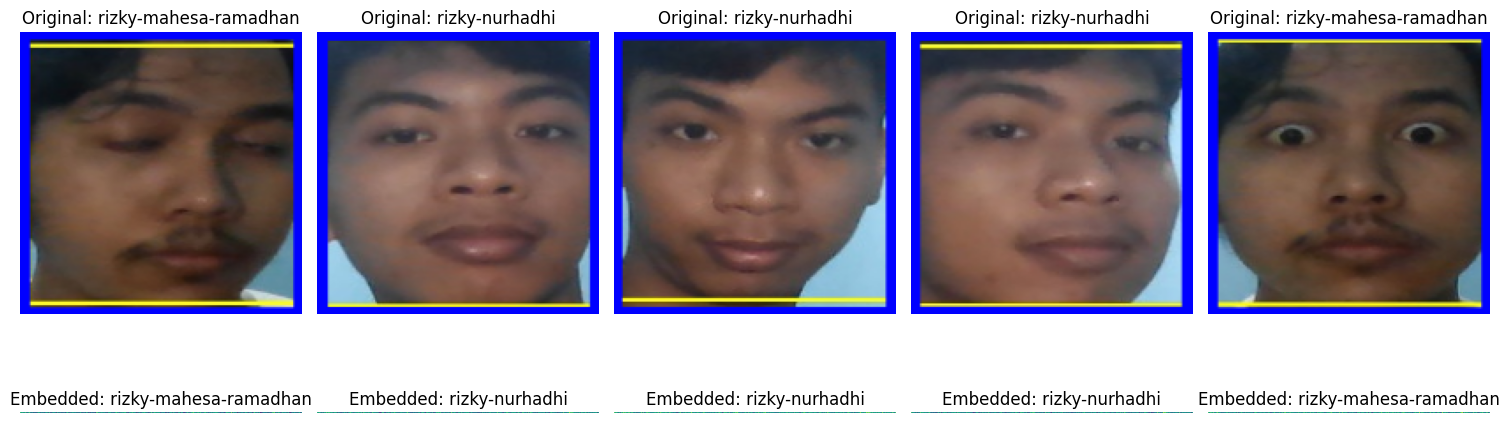

In [86]:
# Choose a few random indices
num_display_samples = 5
sample_indices = random.sample(range(len(EMBEDDED_X)), num_display_samples)

# Display the sample images with their corresponding labels and embeddings
plt.figure(figsize=(15, 6))
for i, index in enumerate(sample_indices):
    plt.subplot(2, num_display_samples, i + 1)
    plt.imshow(X[index])
    plt.title(f"Original: {Y[index]}")
    plt.axis('off')

    plt.subplot(2, num_display_samples, i + num_display_samples + 1)
    plt.imshow(EMBEDDED_X[index].reshape((1, -1)))
    plt.title(f"Embedded: {Y[index]}")
    plt.axis('off')

plt.tight_layout()

In [87]:
# Check correspondence between images in 'X' and labels in 'Y'
for i in range(len(X)):
    print(f"Label: {Y[i]}, File Name: {df['File Name'].iloc[i]}")

Label: rizky-mahesa-ramadhan, File Name: 1207070112_Rizky Mahesa Ramadhan_1.jpg
Label: rizky-mahesa-ramadhan, File Name: 1207070112_Rizky Mahesa Ramadhan_10.jpg
Label: rizky-mahesa-ramadhan, File Name: 1207070112_Rizky Mahesa Ramadhan_100.jpg
Label: rizky-mahesa-ramadhan, File Name: 1207070112_Rizky Mahesa Ramadhan_101.jpg
Label: rizky-mahesa-ramadhan, File Name: 1207070112_Rizky Mahesa Ramadhan_102.jpg
Label: rizky-mahesa-ramadhan, File Name: 1207070112_Rizky Mahesa Ramadhan_103.jpg
Label: rizky-mahesa-ramadhan, File Name: 1207070112_Rizky Mahesa Ramadhan_104.jpg
Label: rizky-mahesa-ramadhan, File Name: 1207070112_Rizky Mahesa Ramadhan_105.jpg
Label: rizky-mahesa-ramadhan, File Name: 1207070112_Rizky Mahesa Ramadhan_106.jpg
Label: rizky-mahesa-ramadhan, File Name: 1207070112_Rizky Mahesa Ramadhan_107.jpg
Label: rizky-mahesa-ramadhan, File Name: 1207070112_Rizky Mahesa Ramadhan_108.jpg
Label: rizky-mahesa-ramadhan, File Name: 1207070112_Rizky Mahesa Ramadhan_109.jpg
Label: rizky-mahesa

## 4. SVM Classification

In [1]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.transform(Y)

NameError: name 'Y' is not defined

In [96]:
Y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [97]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(EMBEDDED_X, Y, shuffle=True, random_state=17)

In [100]:
from sklearn.svm import SVC
model = SVC(kernel='linear', probability=True)
model.fit(X_train, Y_train)

ypreds_train = model.predict(X_train)
ypreds_test = model.predict(X_test)